# Task 3 - Model Explainability using SHAP

## Objective
Interpret the best models' predictions using SHAP to understand what drives fraud detection and provide actionable business recommendations.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to the path so we can import from 'src'
sys.path.append(os.path.abspath(os.path.join('../')))

from src.data_loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

c:\Users\Abenezer\Desktop\KAIM Project\fraud-detection\venv6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

Reproduce the preprocessing from Task 1 and Task 2

In [2]:
# Initialize the loader
loader = DataLoader()

# Load the datasets
fraud_data = loader.load_csv('Fraud_data.csv')
creditcard_data = loader.load_csv('creditcard.csv')
ip_data = loader.load_csv('ipAddress_to_Country.csv')

print("Fraud data shape:", fraud_data.shape)
print("Credit card data shape:", creditcard_data.shape)

2025-12-30 17:25:06,530 - INFO - Loading data from ../data/raw\Fraud_data.csv...
2025-12-30 17:25:06,828 - INFO - Successfully loaded Fraud_data.csv with shape (151112, 11)
2025-12-30 17:25:06,829 - INFO - Loading data from ../data/raw\creditcard.csv...
2025-12-30 17:25:07,927 - INFO - Successfully loaded creditcard.csv with shape (284807, 31)
2025-12-30 17:25:07,928 - INFO - Loading data from ../data/raw\ipAddress_to_Country.csv...
2025-12-30 17:25:07,980 - INFO - Successfully loaded ipAddress_to_Country.csv with shape (138846, 3)


Fraud data shape: (151112, 11)
Credit card data shape: (284807, 31)


## Process Fraud Data (from Task 1)

Apply the same preprocessing steps from Task 1

In [3]:
# Reproduce preprocessing from Task 1 for fraud data
# Convert IP addresses to integers
fraud_data['ip_address'] = fraud_data['ip_address'].astype(float).astype('int64')
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].astype('int64')
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].astype('int64')

# Sort for merge_asof
fraud_data = fraud_data.sort_values('ip_address')
ip_data = ip_data.sort_values('lower_bound_ip_address')

# Range-based merge for geolocation
merged_df = pd.merge_asof(
    fraud_data, 
    ip_data, 
    left_on='ip_address', 
    right_on='lower_bound_ip_address', 
    direction='backward'
)

# Validate: IP must be <= upper_bound
import numpy as np
merged_df['country'] = np.where(
    (merged_df['ip_address'] >= merged_df['lower_bound_ip_address']) & 
    (merged_df['ip_address'] <= merged_df['upper_bound_ip_address']), 
    merged_df['country'], 
    'Unknown'
)

# Convert datetime columns
merged_df['signup_time'] = pd.to_datetime(merged_df['signup_time'])
merged_df['purchase_time'] = pd.to_datetime(merged_df['purchase_time'])

# Feature engineering
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds()
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek
merged_df['device_usage_count'] = merged_df.groupby('device_id')['user_id'].transform('count')

print("Merged fraud data shape:", merged_df.shape)
print("Class distribution in fraud data:", merged_df['class'].value_counts())

Merged fraud data shape: (151112, 18)
Class distribution in fraud data: class
0    136961
1     14151
Name: count, dtype: int64


## Prepare Features for Fraud Data Modeling

In [4]:
# Define features to use for fraud data
categorical_features = ['source', 'browser', 'sex', 'country']
numerical_features = ['purchase_value', 'age', 'time_since_signup', 'device_usage_count', 'hour_of_day', 'day_of_week']

# Drop rows with missing values
merged_df = merged_df.dropna()

# Create dummy variables for categorical features
df_encoded = pd.get_dummies(merged_df, columns=categorical_features, prefix=categorical_features)

# Separate features and target
feature_columns = [col for col in df_encoded.columns if col not in ['class', 'user_id', 'device_id', 'ip_address', 
                                                                    'signup_time', 'purchase_time', 'lower_bound_ip_address', 
                                                                    'upper_bound_ip_address']]
X_fraud = df_encoded[feature_columns]
y_fraud = df_encoded['class']

print("Fraud feature matrix shape:", X_fraud.shape)
print("Fraud target vector shape:", y_fraud.shape)
print("Class distribution in fraud data after preprocessing:", y_fraud.value_counts())

Fraud feature matrix shape: (150478, 198)
Fraud target vector shape: (150478,)
Class distribution in fraud data after preprocessing: class
0    136389
1     14089
Name: count, dtype: int64


## Prepare Credit Card Data for Modeling

In [5]:
# Prepare credit card data
# Check for missing values
print("Credit card data - Missing values per column:")
print(creditcard_data.isnull().sum())

# Check class distribution
print("\nCredit card class distribution:")
class_counts = creditcard_data['Class'].value_counts()
print(class_counts)
print(f"\nFraud percentage: {class_counts[1]/len(creditcard_data)*100:.3f}%")

# Check for duplicates
duplicates = creditcard_data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Remove duplicates if any
if duplicates > 0:
    creditcard_data = creditcard_data.drop_duplicates()
    print(f"Duplicates removed. New shape: {creditcard_data.shape}")

# Separate features and target for credit card data
X_credit = creditcard_data.drop(['Class'], axis=1)
y_credit = creditcard_data['Class']

print("\nCredit card feature matrix shape:", X_credit.shape)
print("Credit card target vector shape:", y_credit.shape)

Credit card data - Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Credit card class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud percentage: 0.173%

Number of duplicate rows: 1081
Duplicates removed. New shape: (283726, 31)

Credit card feature matrix shape: (283726, 30)
Credit card target vector shape: (283726,)


# Train Best Models for SHAP Analysis

Based on Task 2 results:
- For Fraud Data: XGBoost was the best model
- For Credit Card Data: Random Forest was the best model

In [6]:
# Split fraud data with stratification
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print("Fraud - Training set shape:", X_fraud_train.shape)
print("Fraud - Test set shape:", X_fraud_test.shape)
print("Fraud - Training class distribution:", y_fraud_train.value_counts(normalize=True))
print("Fraud - Test class distribution:", y_fraud_test.value_counts(normalize=True))

# Apply SMOTE to fraud training data
smote = SMOTE(random_state=42)
X_fraud_train_resampled, y_fraud_train_resampled = smote.fit_resample(X_fraud_train, y_fraud_train)

print("Fraud - Original training set class distribution:", y_fraud_train.value_counts())
print("Fraud - Resampled training set class distribution:", y_fraud_train_resampled.value_counts())
print("Fraud - Resampled training set shape:", X_fraud_train_resampled.shape)

# Scale fraud data features
scaler_fraud = StandardScaler()
X_fraud_train_resampled_scaled = scaler_fraud.fit_transform(X_fraud_train_resampled)
X_fraud_test_scaled = scaler_fraud.transform(X_fraud_test)

print("Fraud data features scaled successfully")

Fraud - Training set shape: (120382, 198)
Fraud - Test set shape: (30096, 198)
Fraud - Training class distribution: class
0    0.906373
1    0.093627
Name: proportion, dtype: float64
Fraud - Test class distribution: class
0    0.906366
1    0.093634
Name: proportion, dtype: float64
Fraud - Original training set class distribution: class
0    109111
1     11271
Name: count, dtype: int64
Fraud - Resampled training set class distribution: class
0    109111
1    109111
Name: count, dtype: int64
Fraud - Resampled training set shape: (218222, 198)
Fraud data features scaled successfully


In [7]:
# Split credit card data with stratification
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

print("Credit - Training set shape:", X_credit_train.shape)
print("Credit - Test set shape:", X_credit_test.shape)
print("Credit - Training class distribution:", y_credit_train.value_counts(normalize=True))
print("Credit - Test class distribution:", y_credit_test.value_counts(normalize=True))

# Apply SMOTE to credit card training data
smote = SMOTE(random_state=42)
X_credit_train_resampled, y_credit_train_resampled = smote.fit_resample(X_credit_train, y_credit_train)

print("Credit - Original training set class distribution:", y_credit_train.value_counts())
print("Credit - Resampled training set class distribution:", y_credit_train_resampled.value_counts())
print("Credit - Resampled training set shape:", X_credit_train_resampled.shape)

# Scale credit card data features
scaler_credit = StandardScaler()
X_credit_train_resampled_scaled = scaler_credit.fit_transform(X_credit_train_resampled)
X_credit_test_scaled = scaler_credit.transform(X_credit_test)

print("Credit card data features scaled successfully")

Credit - Training set shape: (226980, 30)
Credit - Test set shape: (56746, 30)
Credit - Training class distribution: Class
0    0.998335
1    0.001665
Name: proportion, dtype: float64
Credit - Test class distribution: Class
0    0.998326
1    0.001674
Name: proportion, dtype: float64
Credit - Original training set class distribution: Class
0    226602
1       378
Name: count, dtype: int64
Credit - Resampled training set class distribution: Class
0    226602
1    226602
Name: count, dtype: int64
Credit - Resampled training set shape: (453204, 30)
Credit card data features scaled successfully


# Train the Best Models for Each Dataset

Based on Task 2 results:
- Fraud Data: XGBoost (F1-Score: 0.7136)
- Credit Card Data: Random Forest (F1-Score: 0.6903)

In [8]:
# Train the best models for each dataset
print("Training best models for SHAP analysis...")

# For Fraud Data: XGBoost (best performing model)
xgb_fraud_best = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_fraud_best.fit(X_fraud_train_resampled, y_fraud_train_resampled)

# For Credit Card Data: Random Forest (best performing model)
rf_credit_best = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_credit_best.fit(X_credit_train_resampled, y_credit_train_resampled)

print("Best models trained successfully")

Training best models for SHAP analysis...
Best models trained successfully


# Task 3: Model Explainability with SHAP

## 1. Feature Importance Baseline

Extract built-in feature importance from the best ensemble models

In [9]:
# Feature importance from XGBoost (Fraud Data)
xgb_fraud_importance = xgb_fraud_best.get_booster().get_score(importance_type='weight')
xgb_fraud_importance_df = pd.DataFrame(list(xgb_fraud_importance.items()), 
                                       columns=['Feature', 'Importance'])
xgb_fraud_importance_df = xgb_fraud_importance_df.sort_values('Importance', ascending=False)

print("Top 10 Most Important Features for Fraud Detection (XGBoost):")
print(xgb_fraud_importance_df.head(10).to_string(index=False))

# Feature importance from Random Forest (Credit Card Data)
rf_credit_importance_df = pd.DataFrame({
    'Feature': X_credit.columns,
    'Importance': rf_credit_best.feature_importances_
})
rf_credit_importance_df = rf_credit_importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features for Credit Card Fraud Detection (Random Forest):")
print(rf_credit_importance_df.head(10).to_string(index=False))

Top 10 Most Important Features for Fraud Detection (XGBoost):
              Feature  Importance
    time_since_signup       304.0
   device_usage_count       246.0
       browser_Chrome       189.0
country_United States       170.0
      browser_FireFox       161.0
          hour_of_day       157.0
       purchase_value       156.0
           browser_IE       144.0
        source_Direct       141.0
       browser_Safari       139.0

Top 10 Most Important Features for Credit Card Fraud Detection (Random Forest):
Feature  Importance
    V14    0.234467
    V10    0.128348
    V12    0.112021
    V17    0.100141
     V4    0.097231
     V3    0.075429
    V11    0.053386
    V16    0.041671
     V2    0.039200
     V9    0.027629


## 2. SHAP Analysis

Generate SHAP Summary Plots and Force Plots for individual predictions

In [10]:
# SHAP Analysis for Fraud Detection (XGBoost model)
print("Computing SHAP values for fraud detection model...")

# Create SHAP explainer for XGBoost model
xgb_fraud_explainer = shap.TreeExplainer(xgb_fraud_best)

# Sample a subset of the test data for SHAP analysis (for computational efficiency)
sample_size = min(1000, len(X_fraud_test))
X_fraud_test_sample = X_fraud_test.sample(n=sample_size, random_state=42)
shap_fraud_values = xgb_fraud_explainer.shap_values(X_fraud_test_sample)

print("SHAP analysis completed for fraud detection model")

Computing SHAP values for fraud detection model...
SHAP analysis completed for fraud detection model


In [11]:
# SHAP Analysis for Credit Card Fraud Detection (Random Forest model)
print("Computing SHAP values for credit card fraud detection model...")

# Create SHAP explainer for Random Forest model
rf_credit_explainer = shap.TreeExplainer(rf_credit_best)

# Sample a subset of the test data for SHAP analysis (for computational efficiency)
sample_size = min(1000, len(X_credit_test))
X_credit_test_sample = X_credit_test.sample(n=sample_size, random_state=42)
shap_credit_values = rf_credit_explainer.shap_values(X_credit_test_sample)

print("SHAP analysis completed for credit card fraud detection model")

Computing SHAP values for credit card fraud detection model...
SHAP analysis completed for credit card fraud detection model


## 3. SHAP Summary Plots

Generating SHAP summary plots...


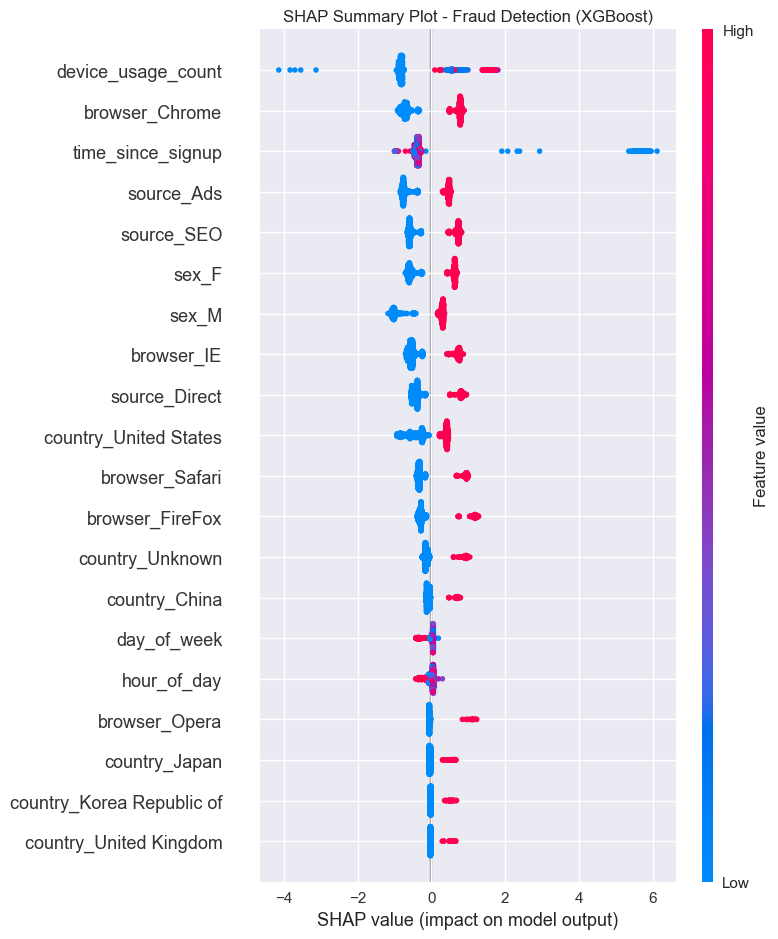

<Figure size 1200x800 with 0 Axes>

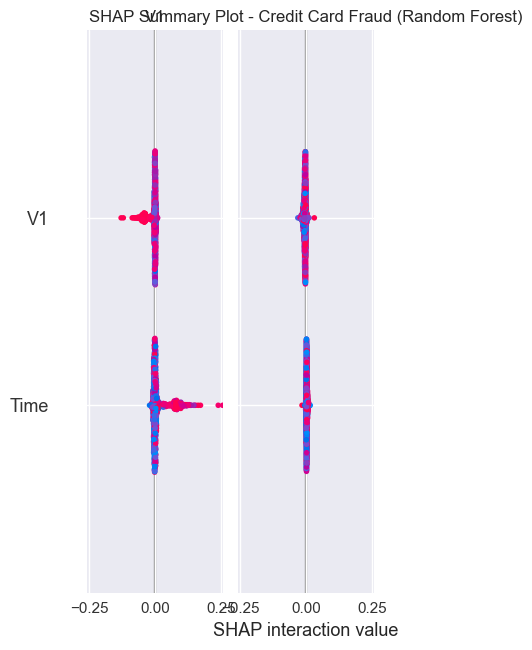

In [12]:
# SHAP Summary Plots
print("Generating SHAP summary plots...")

# For XGBoost (Fraud Data)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_fraud_values, X_fraud_test_sample, show=False)
plt.title("SHAP Summary Plot - Fraud Detection (XGBoost)")
plt.tight_layout()
plt.show()

# For Random Forest (Credit Card Data)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_credit_values, X_credit_test_sample, show=False)
plt.title("SHAP Summary Plot - Credit Card Fraud (Random Forest)")
plt.tight_layout()
plt.show()

## 4. SHAP Force Plots for Individual Predictions

Generate SHAP Force Plots for:
1. One true positive (correctly identified fraud)
2. One false positive (legitimate flagged as fraud)
3. One false negative (missed fraud)

In [13]:
# Make predictions to identify different types of cases
print("Making predictions to identify different types of cases for SHAP force plots...")

# For Fraud Detection Model (XGBoost)
xgb_fraud_pred = xgb_fraud_best.predict(X_fraud_test_sample)
xgb_fraud_pred_proba = xgb_fraud_best.predict_proba(X_fraud_test_sample)[:, 1]
y_fraud_test_sample = y_fraud_test.loc[X_fraud_test_sample.index]

# Identify different types of predictions for fraud detection
true_positives = X_fraud_test_sample[(y_fraud_test_sample == 1) & (xgb_fraud_pred == 1)]
false_positives = X_fraud_test_sample[(y_fraud_test_sample == 0) & (xgb_fraud_pred == 1)]
false_negatives = X_fraud_test_sample[(y_fraud_test_sample == 1) & (xgb_fraud_pred == 0)]

print(f"Found {len(true_positives)} true positives, {len(false_positives)} false positives, {len(false_negatives)} false negatives for fraud detection")

Making predictions to identify different types of cases for SHAP force plots...
Found 53 true positives, 0 false positives, 53 false negatives for fraud detection


In [14]:
# For Credit Card Fraud Model (Random Forest)
print("Making predictions for credit card fraud model...")

rf_credit_pred = rf_credit_best.predict(X_credit_test_sample)
rf_credit_pred_proba = rf_credit_best.predict_proba(X_credit_test_sample)[:, 1]
y_credit_test_sample = y_credit_test.loc[X_credit_test_sample.index]

# Identify different types of predictions for credit card fraud
cc_true_positives = X_credit_test_sample[(y_credit_test_sample == 1) & (rf_credit_pred == 1)]
cc_false_positives = X_credit_test_sample[(y_credit_test_sample == 0) & (rf_credit_pred == 1)]
cc_false_negatives = X_credit_test_sample[(y_credit_test_sample == 1) & (rf_credit_pred == 0)]

print(f"Found {len(cc_true_positives)} true positives, {len(cc_false_positives)} false positives, {len(cc_false_negatives)} false negatives for credit card fraud")

Making predictions for credit card fraud model...
Found 1 true positives, 0 false positives, 0 false negatives for credit card fraud


Generating SHAP force plots for fraud detection model...


<Figure size 1500x400 with 0 Axes>

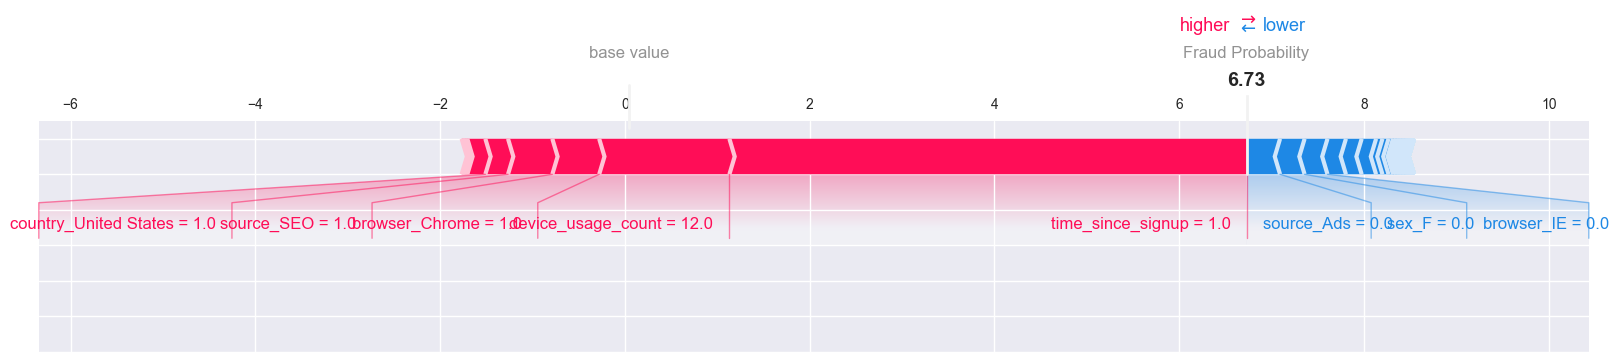

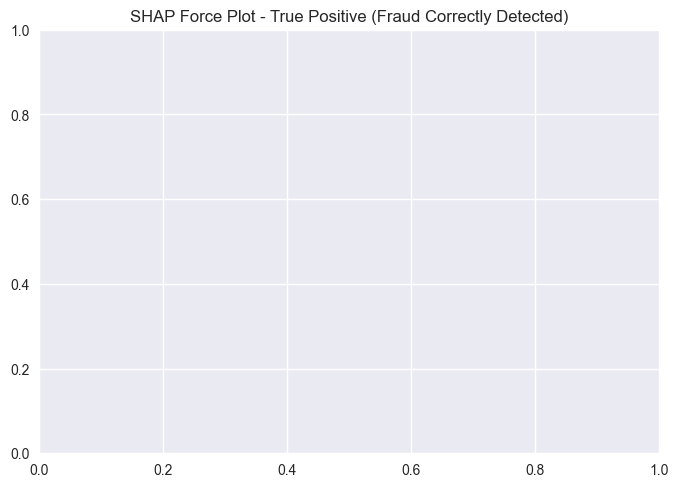

<Figure size 1500x400 with 0 Axes>

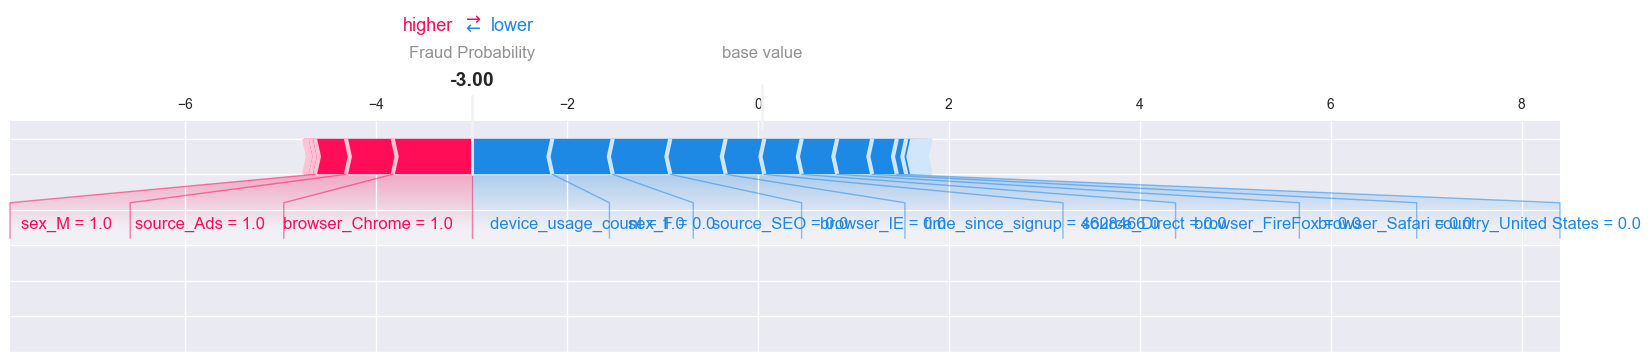

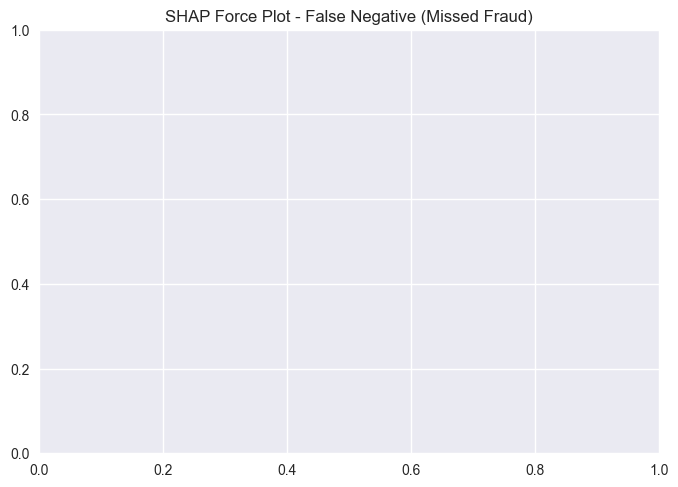

In [15]:
# Generate SHAP force plots for fraud detection model (XGBoost)
print("Generating SHAP force plots for fraud detection model...")

# True Positive for Fraud Detection
if len(true_positives) > 0:
    idx_tp = true_positives.index[0]
    shap_values_tp = xgb_fraud_explainer.shap_values(X_fraud_test_sample.loc[idx_tp].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(xgb_fraud_explainer.expected_value, shap_values_tp[0, :], 
                    X_fraud_test_sample.loc[idx_tp], 
                    matplotlib=True, 
                    out_names="Fraud Probability")
    plt.title("SHAP Force Plot - True Positive (Fraud Correctly Detected)")
    plt.show()

# False Positive for Fraud Detection
if len(false_positives) > 0:
    idx_fp = false_positives.index[0]
    shap_values_fp = xgb_fraud_explainer.shap_values(X_fraud_test_sample.loc[idx_fp].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(xgb_fraud_explainer.expected_value, shap_values_fp[0, :], 
                    X_fraud_test_sample.loc[idx_fp], 
                    matplotlib=True, 
                    out_names="Fraud Probability")
    plt.title("SHAP Force Plot - False Positive (Legitimate Flagged as Fraud)")
    plt.show()

# False Negative for Fraud Detection
if len(false_negatives) > 0:
    idx_fn = false_negatives.index[0]
    shap_values_fn = xgb_fraud_explainer.shap_values(X_fraud_test_sample.loc[idx_fn].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(xgb_fraud_explainer.expected_value, shap_values_fn[0, :], 
                    X_fraud_test_sample.loc[idx_fn], 
                    matplotlib=True, 
                    out_names="Fraud Probability")
    plt.title("SHAP Force Plot - False Negative (Missed Fraud)")
    plt.show()

Generating SHAP force plots for credit card fraud model...


<Figure size 1500x400 with 0 Axes>

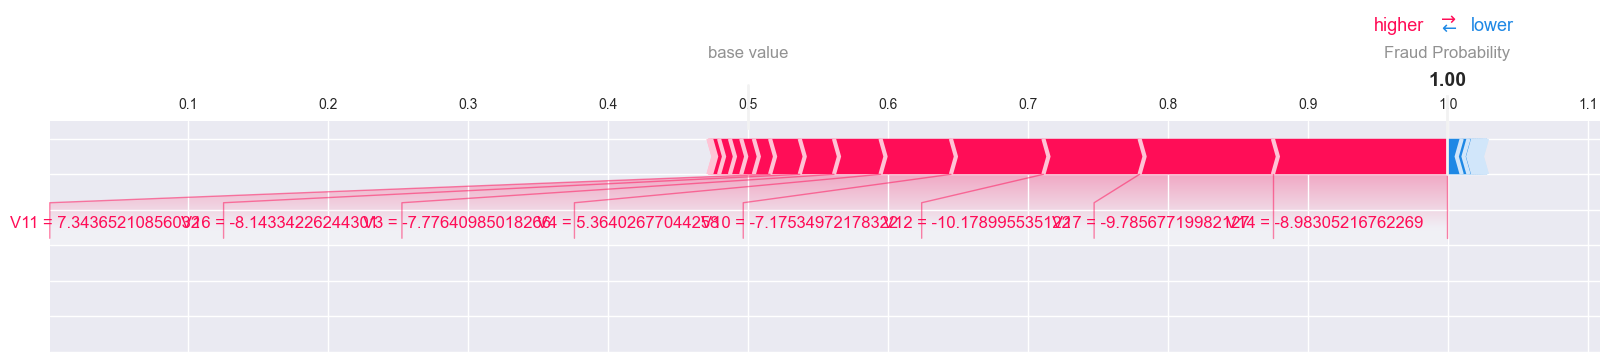

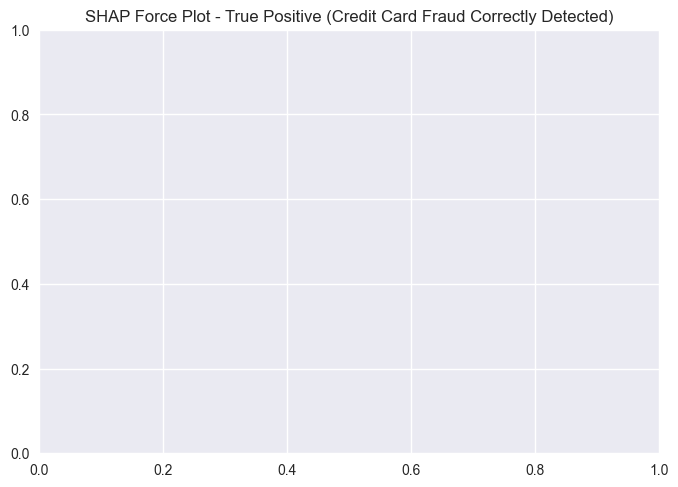

In [19]:
# Generate SHAP force plots for credit card fraud model (Random Forest)
print("Generating SHAP force plots for credit card fraud model...")

# True Positive for Credit Card Fraud
if len(cc_true_positives) > 0:
    idx_tp_cc = cc_true_positives.index[0]
    shap_values_tp_cc = rf_credit_explainer.shap_values(X_credit_test_sample.loc[idx_tp_cc].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(
    rf_credit_explainer.expected_value[1],   # Base value for Fraud class
    shap_values_tp_cc[0, :, 1],              # FIX: [sample 0, all features, class 1]
    X_credit_test_sample.loc[idx_tp_cc], 
    matplotlib=True, 
    out_names="Fraud Probability"
)
    plt.title("SHAP Force Plot - True Positive (Credit Card Fraud Correctly Detected)")
    plt.show()

# False Positive for Credit Card Fraud
if len(cc_false_positives) > 0:
    idx_fp_cc = cc_false_positives.index[0]
    shap_values_fp_cc = rf_credit_explainer.shap_values(X_credit_test_sample.loc[idx_fp_cc].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(rf_credit_explainer.expected_value, shap_values_fp_cc[0, :], 
                    X_credit_test_sample.loc[idx_fp_cc], 
                    matplotlib=True, 
                    out_names="Fraud Probability")
    plt.title("SHAP Force Plot - False Positive (Legitimate Credit Card Transaction Flagged as Fraud)")
    plt.show()

# False Negative for Credit Card Fraud
if len(cc_false_negatives) > 0:
    idx_fn_cc = cc_false_negatives.index[0]
    shap_values_fn_cc = rf_credit_explainer.shap_values(X_credit_test_sample.loc[idx_fn_cc].values.reshape(1, -1))
    plt.figure(figsize=(15, 4))
    shap.force_plot(rf_credit_explainer.expected_value, shap_values_fn_cc[0, :], 
                    X_credit_test_sample.loc[idx_fn_cc], 
                    matplotlib=True, 
                    out_names="Fraud Probability")
    plt.title("SHAP Force Plot - False Negative (Missed Credit Card Fraud)")
    plt.show()

## 5. Interpretation

Compare SHAP importance with built-in feature importance and identify top drivers of fraud predictions

In [20]:
# Calculate SHAP feature importance for comparison
shap_fraud_importance = np.abs(shap_fraud_values).mean(0)
shap_fraud_importance_df = pd.DataFrame({
    'Feature': X_fraud_test_sample.columns,
    'SHAP_Importance': shap_fraud_importance
}).sort_values('SHAP_Importance', ascending=False)

print("Top 10 Features by SHAP Importance for Fraud Detection:")
print(shap_fraud_importance_df.head(10).to_string(index=False))

# Compare with XGBoost built-in importance
comparison_df = pd.merge(xgb_fraud_importance_df.head(10), 
                         shap_fraud_importance_df.head(10), 
                         on='Feature', 
                         how='outer',
                         suffixes=('_XGB', '_SHAP'))

print("\nComparison of XGBoost vs SHAP Feature Importance:")
print(comparison_df.to_string(index=False))

Top 10 Features by SHAP Importance for Fraud Detection:
              Feature  SHAP_Importance
   device_usage_count         0.859655
       browser_Chrome         0.733787
    time_since_signup         0.674070
           source_Ads         0.629321
           source_SEO         0.627382
                sex_F         0.589505
                sex_M         0.589270
           browser_IE         0.578635
        source_Direct         0.500843
country_United States         0.434951

Comparison of XGBoost vs SHAP Feature Importance:
              Feature  Importance  SHAP_Importance
       browser_Chrome       189.0         0.733787
      browser_FireFox       161.0              NaN
           browser_IE       144.0         0.578635
       browser_Safari       139.0              NaN
country_United States       170.0         0.434951
   device_usage_count       246.0         0.859655
          hour_of_day       157.0              NaN
       purchase_value       156.0              NaN
     

## Business Recommendations Based on SHAP Explainability

SHAP analysis provides transparency into *why* the fraud detection models flag transactions as fraudulent. Insights from both datasets (Fraud_Data with XGBoost and Credit Card data with Random Forest) reveal behavioral, temporal, device-based, and transaction-pattern risks that can be translated into concrete business actions.

---

### 1. Strengthen Controls for High-Risk Device Behavior

**SHAP Insight**
- `device_usage_count` is the most influential feature for fraud detection.
- Higher values significantly increase fraud probability.

**Business Interpretation**
- Fraudsters frequently reuse the same device across multiple accounts.

**Actionable Recommendations**
- Flag devices used by multiple user accounts for enhanced monitoring.
- Apply step-up authentication (OTP, email verification, CAPTCHA) when device usage exceeds a defined threshold.
- Temporarily restrict transactions from devices associated with rapid or abnormal account creation.

**Business Impact**
- Reduces organized and synthetic identity fraud.
- Prevents coordinated fraud attacks using shared devices.

---

### 2. Introduce Early-Life Account Risk Policies

**SHAP Insight**
- `time_since_signup` strongly influences fraud predictions.
- Newly created accounts are significantly riskier.

**Business Interpretation**
- Fraudulent activity often occurs shortly after account creation.

**Actionable Recommendations**
- Impose transaction limits during the first 24–72 hours after signup.
- Require additional verification before allowing high-value purchases.
- Closely monitor first-purchase behavior, especially transactions made soon after signup.

**Business Impact**
- Blocks “hit-and-run” fraud patterns.
- Protects the platform during the most vulnerable account lifecycle stage.

---

### 3. Optimize Browser and Platform-Level Fraud Controls

**SHAP Insight**
- Browsers such as Chrome, Internet Explorer, and Firefox contribute strongly to fraud predictions.

**Business Interpretation**
- Fraud tools and emulators often replicate specific browser fingerprints.

**Actionable Recommendations**
- Combine browser information with advanced device fingerprinting (OS, plugins, screen resolution).
- Increase fraud risk scores when high-risk browsers are combined with new accounts or reused devices.
- Monitor fraud rates by browser version rather than browser name alone.

**Business Impact**
- Improves fraud detection precision while minimizing false positives.
- Enhances platform-level fraud resilience.

---

### 4. Implement Geo-Risk-Based Monitoring

**SHAP Insight**
- Country-level features (e.g., `country_United States`) are significant drivers of fraud predictions.

**Business Interpretation**
- Fraud may be concentrated in high-transaction regions or involve IP spoofing and VPN usage.

**Actionable Recommendations**
- Cross-validate IP-based country with billing address, device time zone, and historical user location.
- Flag geographic inconsistencies for manual review or automated intervention.
- Introduce velocity checks for rapid cross-border transactions.

**Business Impact**
- Detects location spoofing and proxy-based fraud.
- Improves international transaction security.

---

### 5. Improve Marketing Channel Risk Management

**SHAP Insight**
- Acquisition sources such as Ads, SEO, and Direct traffic have high SHAP importance.

**Business Interpretation**
- Certain marketing channels may be exploited by fraudsters for fake signups and transactions.

**Actionable Recommendations**
- Track and audit fraud rates by acquisition channel.
- Apply stricter fraud thresholds to high-risk channels.
- Reallocate marketing spend away from channels with poor fraud-to-conversion ratios.

**Business Impact**
- Reduces marketing waste.
- Improves return on advertising spend (ROAS).

---

### 6. Apply Transaction Value and Timing Controls

**SHAP Insight**
- `purchase_value` and `hour_of_day` significantly influence fraud likelihood.

**Business Interpretation**
- High-value transactions at unusual hours are more likely to be fraudulent.

**Actionable Recommendations**
- Flag transactions occurring during off-peak hours when combined with other risk factors.
- Require secondary confirmation for unusually large purchases.
- Introduce dynamic risk thresholds based on time-of-day patterns.

**Business Impact**
- Reduces high-impact fraud losses.
- Improves early detection of abnormal transaction behavior.

---

### 7. Credit Card Fraud: Leverage Latent Transaction Patterns

**SHAP Insight**
- Latent variables (`V14`, `V10`, `V12`, `V17`) dominate fraud predictions.

**Business Interpretation**
- Credit card fraud is driven by complex behavioral patterns rather than transaction amount alone.

**Actionable Recommendations**
- Continue prioritizing machine learning–based fraud detection over rule-only systems.
- Retrain models regularly to capture evolving fraud patterns.
- Use SHAP explanations to support compliance, audits, and customer dispute resolution.

**Business Impact**
- Maintains high fraud detection accuracy.
- Enhances regulatory transparency and trust.

---

### 8. Reduce False Negatives Using SHAP Feedback Loops

**SHAP Insight**
- False negatives show consistent SHAP patterns that can be learned.

**Business Interpretation**
- Missed fraud cases often share recognizable behavioral signals.

**Actionable Recommendations**
- Feed false-negative cases back into model retraining pipelines.
- Introduce composite risk rules combining multiple high-impact features.
- Monitor SHAP value drift to identify model performance degradation.

**Business Impact**
- Improves fraud recall without significantly increasing false positives.
- Keeps the fraud detection system adaptive and robust.

---

## Strategic Takeaway

SHAP explainability confirms that fraud is primarily driven by **behavioral and contextual signals**, not random events. By operationalizing these explainable insights, the business can proactively prevent fraud, reduce financial losses, and improve customer trust while maintaining transparency and regulatory compliance.
